In [1]:
!pip install -q catboost pandas scikit-learn joblib shap optuna wandb seaborn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 30.2 MB/s eta 0:00:00


 Импорты и настройки

In [2]:
import math
import time

import pandas as pd
import numpy as np

import joblib
import shap
import optuna
import wandb

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", font_scale=1.1)

from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression

RANDOM_STATE = 42

DATA_PATH = "ch_rifles.csv"
TARGET_COL = "price"

# Базовые числовые признаки
BASE_NUM_FEATURES = [
    "float", "pattern", "stattrak",
    "backside_blue", "playside_blue",
    "stickers_count", "stickers_total_value", "stickers_avg_value", "stickers_max_value",
    "slot0_price", "slot1_price", "slot2_price", "slot3_price"
]

# Сконструированные (engineered) числовые признаки
ENGINEERED_NUM_FEATURES = ["blue_score", "blue_tier"]

NUM_FEATURES = BASE_NUM_FEATURES + ENGINEERED_NUM_FEATURES

# Категориальные признаки
CAT_FEATURES = ["weapon", "skin", "wear", "pattern_style"]

ALL_FEATURES = NUM_FEATURES + CAT_FEATURES


### 1. Импорты и настройки

На этом шаге:

- подключаем библиотеки для:
  - анализа данных (`pandas`, `numpy`),
  - визуализации (`matplotlib`, `seaborn`),
  - моделей и метрик (`catboost`, `sklearn`),
  - оптимизации гиперпараметров (`optuna`),
  - интерпретации (`shap`),
  - логирования экспериментов (`wandb`),
  - сохранения моделей (`joblib`);
- задаем путь к датасету `ch_rifles.csv` и имя целевого признака `price`;
- описываем перечень признаков:
  - базовые числовые (float, pattern, проценты синего и наклейки),
  - сконструированные (`blue_score`, `blue_tier`),
  - категориальные (`weapon`, `skin`, `wear`, `pattern_style`).


#Загрузка датасета и генерация фич для Case Hardened

In [3]:

df = pd.read_csv(DATA_PATH)
df.columns = [c.strip() for c in df.columns]

print("Размер датасета:", df.shape)
display(df.head())

# Проверка обязательных колонок
for col in BASE_NUM_FEATURES + ["weapon", "skin", "wear", TARGET_COL]:
    if col not in df.columns:
        raise ValueError(f"Нет колонки: {col}")

# 2.2. Генерация фич, связанных с синевой (blue) и стилем паттерна

def add_pattern_features(df_in: pd.DataFrame) -> pd.DataFrame:
    df = df_in.copy()

    # заполняем NaN по синим процентам нулями
    df[["playside_blue", "backside_blue"]] = df[["playside_blue", "backside_blue"]].fillna(0.0)

    # blue_score — взвешенная сумма синевы на playside и backside
    df["blue_score"] = 0.7 * df["playside_blue"] + 0.3 * df["backside_blue"]

    # blue_tier — дискретный "тір" по playside синеве
    def to_tier_blue(x: float) -> int:
        if x >= 60:
            return 3  # топовый Blue Gem
        if x >= 35:
            return 2  # хороший mix
        if x >= 15:
            return 1  # немного синевы
        return 0      # почти без синего

    df["blue_tier"] = df["playside_blue"].apply(to_tier_blue)

    # pattern_style — категориальное описание паттерна
    def pattern_style(row):
        pb = row["playside_blue"]
        if pb >= 60:
            return "blue_gem"
        if pb >= 30:
            return "blue_mix"
        return "other"

    df["pattern_style"] = df.apply(pattern_style, axis=1)

    return df

df = add_pattern_features(df)
print("\nПосле генерации фич:")
display(df.head())


Размер датасета: (8387, 28)


,weapon,skin,wear,float,pattern,stattrak,price,phase,backside_blue,backside_purple,...,stickers_total_over_price,slot0_name,slot0_price,slot1_name,slot1_price,slot2_name,slot2_price,slot3_name,slot3_price,market_hash_name
0,AK-47,Case Hardened,Factory New,0.067468,349,0,544.67,NaN,9.45,NaN,...,0.287550,Sticker | Cloud9 (Foil) | MLG Columbus 2016,49.04,Sticker | shroud (Foil) | Krakow 2017,58.54,Sticker | Cloud9 (Foil) | MLG Columbus 2016,49.04,NaN,0.00,AK-47 | Case Hardened (Factory New)
1,AK-47,Case Hardened,Factory New,0.072947,349,0,420.44,NaN,9.45,NaN,...,0.000000,NaN,0.00,NaN,0.00,NaN,0.00,NaN,0.00,AK-47 | Case Hardened (Factory New)
2,AK-47,Case Hardened,Factory New,0.074640,349,0,431.38,NaN,9.45,NaN,...,0.000000,NaN,0.00,NaN,0.00,NaN,0.00,NaN,0.00,AK-47 | Case Hardened (Factory New)
3,AK-47,Case Hardened,Factory New,0.017126,60,0,630.16,NaN,8.51,NaN,...,0.532722,Sticker | G2 Esports (Holo) | Atlanta 2017,94.86,Sticker | G2 Esports (Holo) | Atlanta 2017,94.86,Sticker | G2 Esports (Holo) | Atlanta 2017,94.86,Sticker | Natus Vincere (Holo) | Atlanta 2017,51.12,AK-47 | Case Hardened (Factory New)
4,AK-47,Case Hardened,Factory New,0.009009,60,0,430.69,NaN,8.51,NaN,...,0.000000,NaN,0.00,NaN,0.00,NaN,0.00,NaN,0.00,AK-47 | Case Hardened (Factory New)



После генерации фич:


,weapon,skin,wear,float,pattern,stattrak,price,phase,backside_blue,backside_purple,...,slot1_name,slot1_price,slot2_name,slot2_price,slot3_name,slot3_price,market_hash_name,blue_score,blue_tier,pattern_style
0,AK-47,Case Hardened,Factory New,0.067468,349,0,544.67,NaN,9.45,NaN,...,Sticker | shroud (Foil) | Krakow 2017,58.54,Sticker | Cloud9 (Foil) | MLG Columbus 2016,49.04,NaN,0.00,AK-47 | Case Hardened (Factory New),21.462,1,other
1,AK-47,Case Hardened,Factory New,0.072947,349,0,420.44,NaN,9.45,NaN,...,NaN,0.00,NaN,0.00,NaN,0.00,AK-47 | Case Hardened (Factory New),21.462,1,other
2,AK-47,Case Hardened,Factory New,0.074640,349,0,431.38,NaN,9.45,NaN,...,NaN,0.00,NaN,0.00,NaN,0.00,AK-47 | Case Hardened (Factory New),21.462,1,other
3,AK-47,Case Hardened,Factory New,0.017126,60,0,630.16,NaN,8.51,NaN,...,Sticker | G2 Esports (Holo) | Atlanta 2017,94.86,Sticker | G2 Esports (Holo) | Atlanta 2017,94.86,Sticker | Natus Vincere (Holo) | Atlanta 2017,51.12,AK-47 | Case Hardened (Factory New),12.710,0,other
4,AK-47,Case Hardened,Factory New,0.009009,60,0,430.69,NaN,8.51,NaN,...,NaN,0.00,NaN,0.00,NaN,0.00,AK-47 | Case Hardened (Factory New),12.710,0,other


###  Загрузка и генерация фич для Case Hardened

Здесь мы:

1. Загружаем исходный датасет `ch_rifles.csv`.
2. Добавляем доменно-осмысленные фичи:
   - `blue_score` — агрегированная «синева» с большей важностью playside;
   - `blue_tier` — дискретная оценка уровня синевы (0–3);
   - `pattern_style` — категориальная метка паттерна:
     - `blue_gem` — топовые паттерны с playside_blue ≥ 60;
     - `blue_mix` — комбинации с умеренной синевой;
     - `other` — обычные паттерны.

Эти engineered-фичи помогают модели учитывать рыночную логику ценообразования Case Hardened:
чем больше синевы на playside и чем выше tier, тем выше ожидаемая цена.


#EDA

##Распределение цены

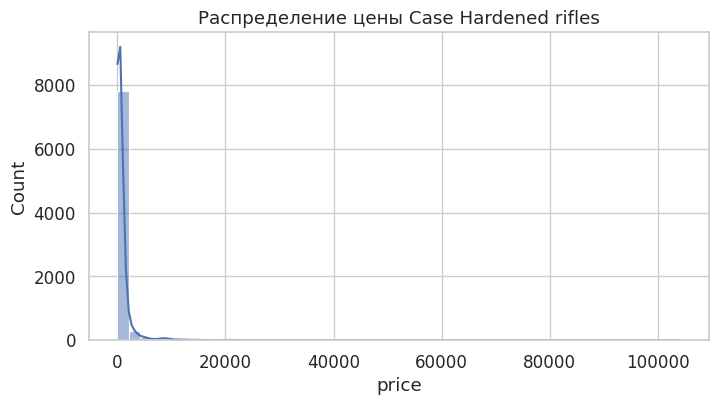

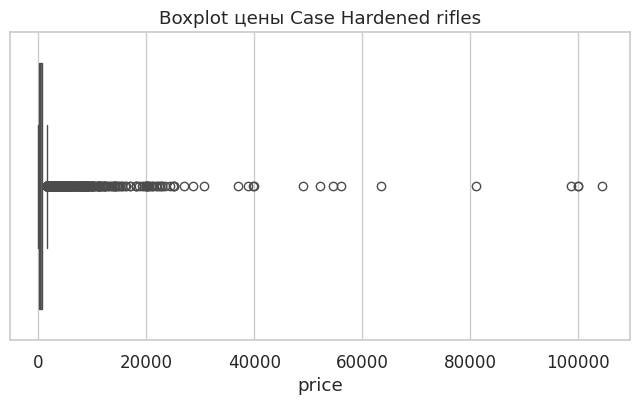

In [4]:

plt.figure(figsize=(8, 4))
sns.histplot(df[TARGET_COL], bins=50, kde=True)
plt.title("Распределение цены Case Hardened rifles")
plt.xlabel("price")
plt.show()

plt.figure(figsize=(8, 4))
sns.boxplot(x=df[TARGET_COL])
plt.title("Boxplot цены Case Hardened rifles")
plt.show()


### Распределение цены

Цены имеют право-скошенное распределение: большинство ружей торгуется в среднем диапазоне,  
но есть редкие дорогие Blue Gem-паттерны, которые образуют хвост распределения и выбросы на boxplot.  
Это типичная ситуация для кейс-хардов и объясняет, почему мы используем MAE и RMSE вместе и внимательно относимся к выбросам.


##Распределение по weapon, wear и pattern_style

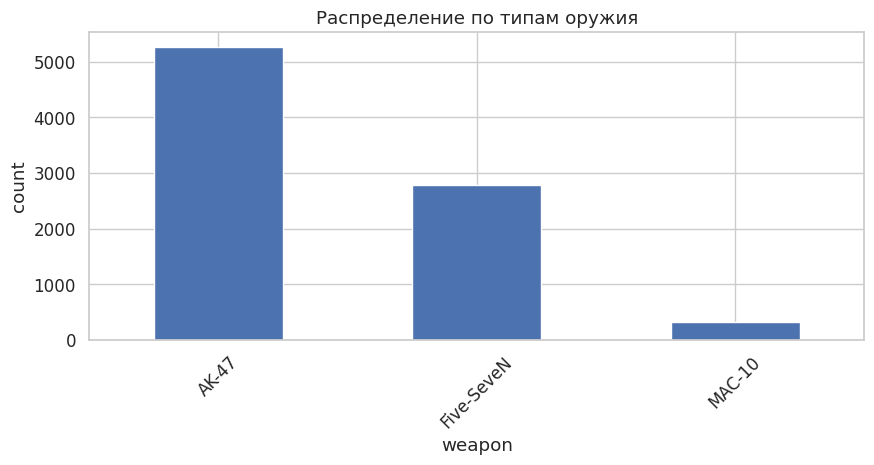

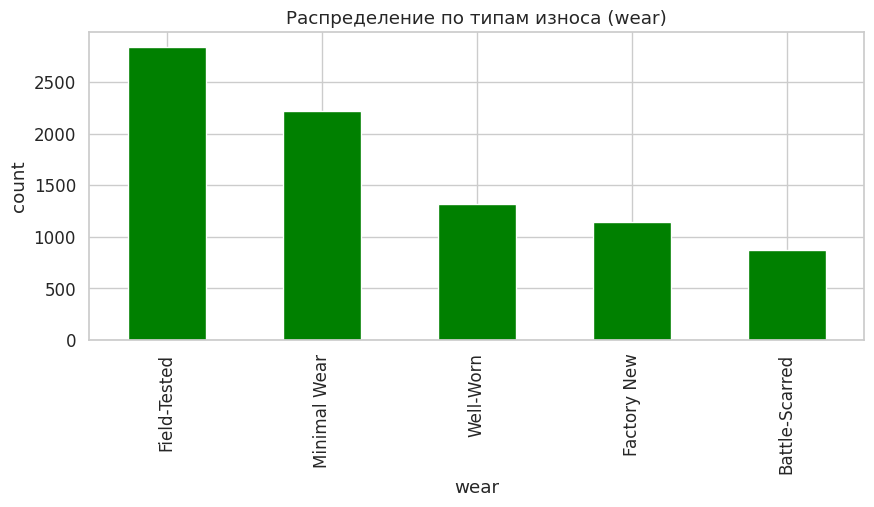

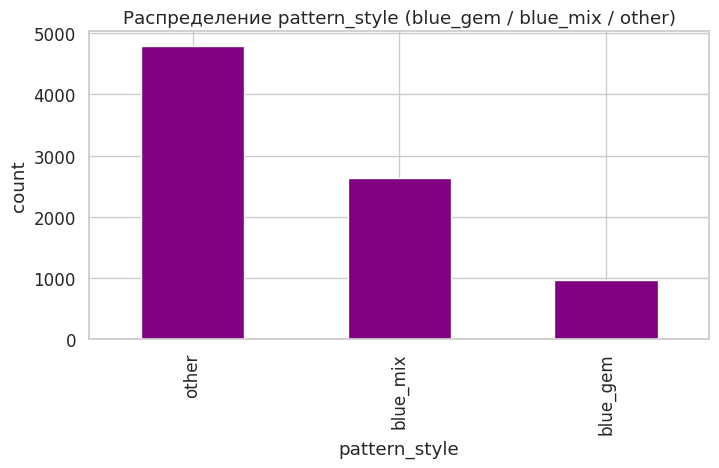

In [5]:

plt.figure(figsize=(10, 4))
df["weapon"].value_counts().plot(kind="bar")
plt.title("Распределение по типам оружия")
plt.xlabel("weapon")
plt.ylabel("count")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10, 4))
df["wear"].value_counts().plot(kind="bar", color="green")
plt.title("Распределение по типам износа (wear)")
plt.xlabel("wear")
plt.ylabel("count")
plt.show()

plt.figure(figsize=(8, 4))
df["pattern_style"].value_counts().plot(kind="bar", color="purple")
plt.title("Распределение pattern_style (blue_gem / blue_mix / other)")
plt.xlabel("pattern_style")
plt.ylabel("count")
plt.show()


###  Распределение по weapon, wear и pattern_style

- По `weapon` видно, какие винтовки в датасете встречаются чаще — именно на них модель будет обучена лучше.
- По `wear` (износ) видно, какие состояния чаще торгуются (обычно FN/MW).
- Распределение `pattern_style` показывает, насколько редки настоящие `blue_gem` по сравнению с `blue_mix` и `other`.

Это важно при интерпретации качества модели: по редким паттернам и редким винтовкам ошибок может быть больше, чем по массовым.


##Распределения playside_blue, backside_blue, blue_score и blue_tier

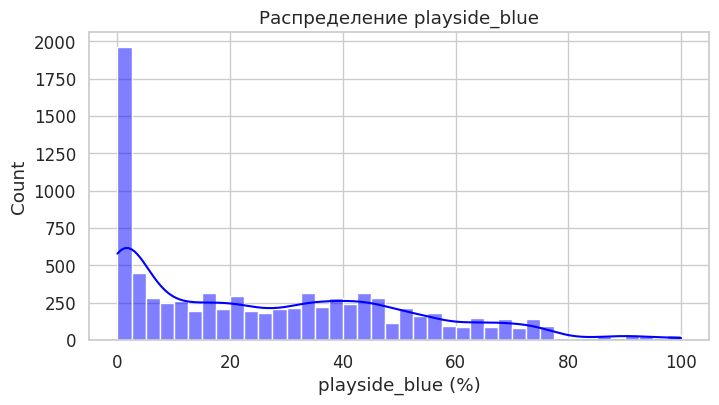

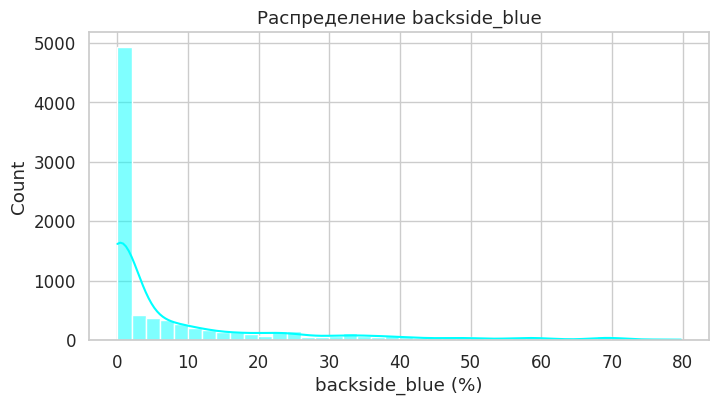

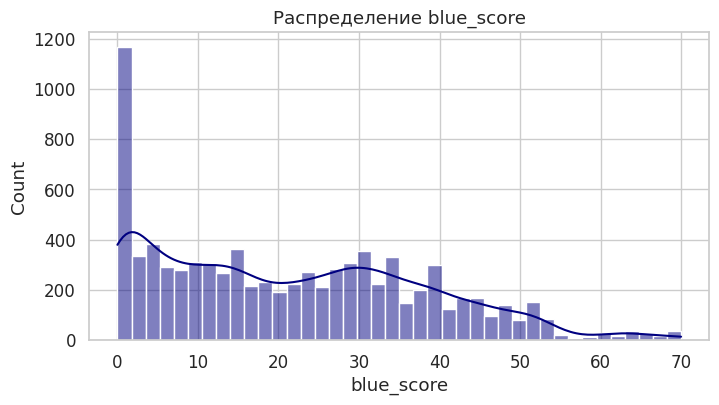

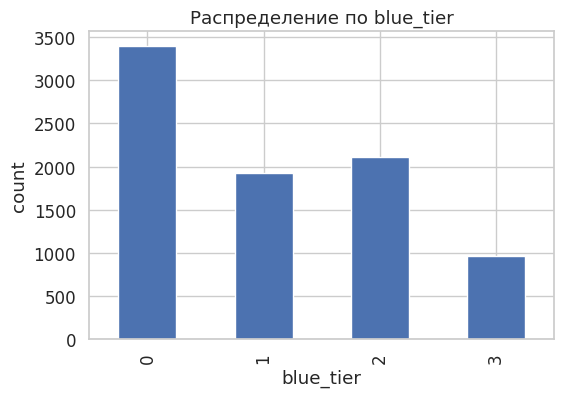

In [6]:

plt.figure(figsize=(8, 4))
sns.histplot(df["playside_blue"], bins=40, kde=True, color="blue")
plt.title("Распределение playside_blue")
plt.xlabel("playside_blue (%)")
plt.show()

plt.figure(figsize=(8, 4))
sns.histplot(df["backside_blue"], bins=40, kde=True, color="cyan")
plt.title("Распределение backside_blue")
plt.xlabel("backside_blue (%)")
plt.show()

plt.figure(figsize=(8, 4))
sns.histplot(df["blue_score"], bins=40, kde=True, color="navy")
plt.title("Распределение blue_score")
plt.xlabel("blue_score")
plt.show()

plt.figure(figsize=(6, 4))
df["blue_tier"].value_counts().sort_index().plot(kind="bar")
plt.title("Распределение по blue_tier")
plt.xlabel("blue_tier")
plt.ylabel("count")
plt.show()


### Синева паттерна: playside_blue, backside_blue, blue_score и blue_tier

- `playside_blue` и `backside_blue` показывают, какая доля поверхности занимает синий цвет на каждой стороне.
- `blue_score` агрегирует эту информацию с более высоким весом для playside (то, что игрок и рынок видят чаще).
- `blue_tier` переводит непрерывный показатель в дискретные категории (0–3), что удобно для анализа и интерпретации.

Распределения показывают, что топовые Blue Gem паттерны (tier 3) — редки,  
а большинство паттернов — это `other` или `blue_mix`. Это отражает реальную редкость настоящих Blue Gem’ов.


##Корреляционная матрица для числовых фичей

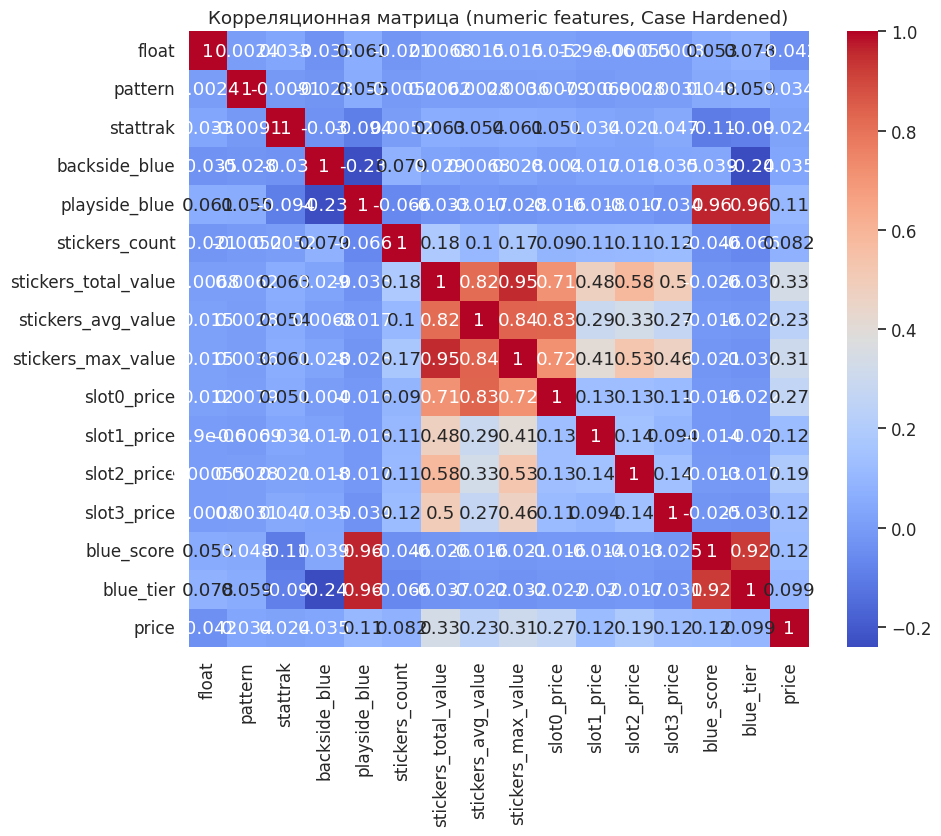

In [8]:
numeric_cols = NUM_FEATURES + [TARGET_COL]
plt.figure(figsize=(10, 8))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap="coolwarm")
plt.title("Корреляционная матрица (numeric features, Case Hardened)")
plt.show()

### Корреляционная матрица

Корреляции показывают:

- положительную связь `blue_score` / `blue_tier` с `price` — чем более синий паттерн, тем выше цена;
- отрицательную связь `float` с ценой (износ снижает стоимость);
- положительное влияние наклеек (`stickers_total_value`, `slot*_price`) на итоговую цену.

При этом коэффициенты далеки от ±1, что говорит о нелинейном и многомерном характере зависимости.  
Это оправдывает использование CatBoost, который умеет ловить сложные взаимодействия между признаками.


##Зависимость blue_score и цены

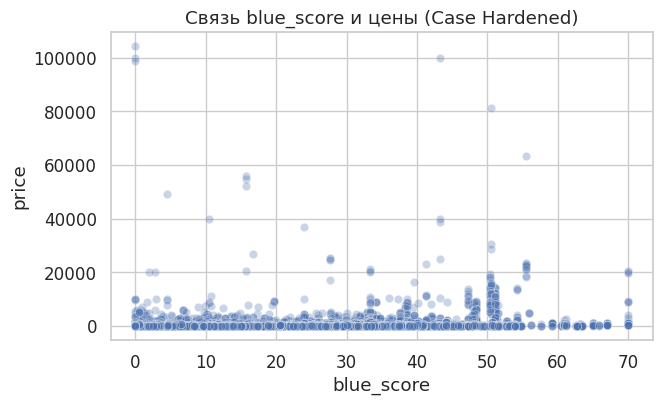

In [7]:
plt.figure(figsize=(7, 4))
sns.scatterplot(x="blue_score", y=TARGET_COL, data=df, alpha=0.3)
plt.title("Связь blue_score и цены (Case Hardened)")
plt.xlabel("blue_score")
plt.ylabel("price")
plt.show()

### Связь blue_score и цены

Scatterplot показывает, что с ростом `blue_score` цена в среднем растёт,  
но наблюдается большой разброс — т.е. на стоимость влияют и другие факторы (weapon, float, наклейки).

Модель должна воспринимать `blue_score` как один из ключевых числовых признаков для CH-паттернов,  
но при этом учитывать и контекст (тип оружия, качество наклеек и т.д.).


##Зависимость blue_tier и цены



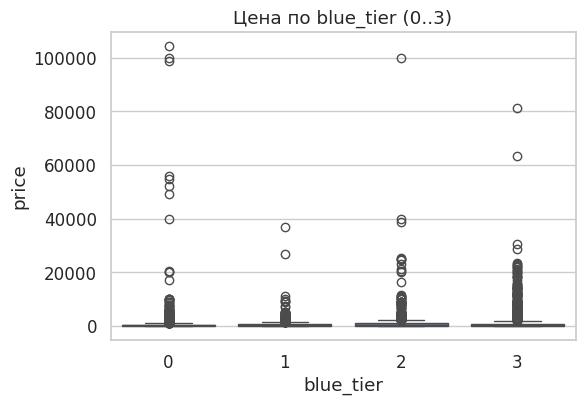

In [9]:

plt.figure(figsize=(6, 4))
sns.boxplot(x="blue_tier", y=TARGET_COL, data=df)
plt.title("Цена по blue_tier (0..3)")
plt.xlabel("blue_tier")
plt.ylabel("price")
plt.show()


###  Связь blue_tier и цены

Boxplot показывает ожидаемую картину:

- при `blue_tier = 0` и `1` медианы относительно низкие;
- при `blue_tier = 2` цена повышается;
- при `blue_tier = 3` (Blue Gem) медиана и верхние значения заметно выше.

Это подтверждает корректность введения фичи `blue_tier` и её важность для модели.


## Влияние StatTrak на цену

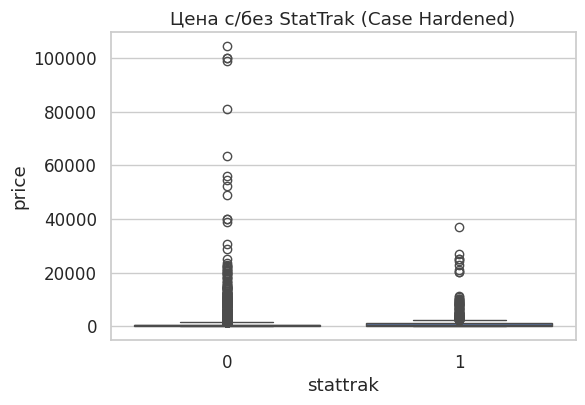

In [10]:

plt.figure(figsize=(6, 4))
sns.boxplot(x="stattrak", y=TARGET_COL, data=df)
plt.title("Цена с/без StatTrak (Case Hardened)")
plt.xlabel("stattrak")
plt.ylabel("price")
plt.show()


### Влияние StatTrak на цену

Сравнение распределений цен показывает, что наличие StatTrak чаще всего смещает цену вверх.  
Значит, `stattrak` — важный бинарный признак, который нужно включать в модель как числовой (0/1).


##Средняя цена по типам оружия

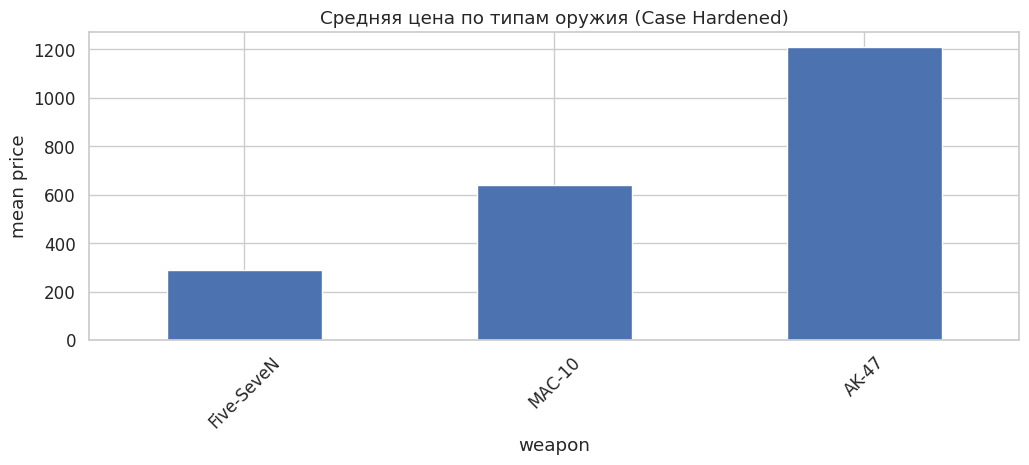

In [11]:
weapon_mean = df.groupby("weapon")[TARGET_COL].mean().sort_values()
plt.figure(figsize=(12, 4))
weapon_mean.plot(kind="bar")
plt.title("Средняя цена по типам оружия (Case Hardened)")
plt.xlabel("weapon")
plt.ylabel("mean price")
plt.xticks(rotation=45)
plt.show()

### Средняя цена по типам оружия

График показывает базовый ценовой уровень для каждого оружия.  
Даже при одинаковом паттерне и одинаковой синеве Case Hardened на дорогой винтовке будет стоить больше,  
чем на дешёвой. Это подтверждает, что `weapon` — принципиально важный категориальный признак.


#ML

##Препроцессинг и сплит (train/val/test)

In [20]:
# === Старый стиль: только train / test 80/20, как в прошлом скрипте ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, shuffle=True
)

print(f"Train: {len(X_train)}, Test: {len(X_test)}")

cat_indices = [X.columns.get_loc(c) for c in CAT_FEATURES]
train_pool = Pool(X_train, y_train, cat_features=cat_indices)
test_pool  = Pool(X_test,  y_test,  cat_features=cat_indices)

# для baseline и tuned:
val_pool = test_pool   # CatBoost будет смотреть на тот же самый набор

# # 70/15/15: train / val / test
# X_train_full, X_test, y_train_full, y_test = train_test_split(
#     X, y, test_size=0.15, random_state=RANDOM_STATE, shuffle=True
# )

# X_train, X_val, y_train, y_val = train_test_split(
#     X_train_full, y_train_full, test_size=0.1765,  # ~15% от всего
#     random_state=RANDOM_STATE, shuffle=True
# )

# print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

# cat_indices = [X.columns.get_loc(c) for c in CAT_FEATURES]
# train_pool = Pool(X_train, y_train, cat_features=cat_indices)
# val_pool   = Pool(X_val,   y_val,   cat_features=cat_indices)
# test_pool  = Pool(X_test,  y_test,  cat_features=cat_indices)



Train: 6709, Test: 1678


##Baseline CatBoost

In [13]:

baseline_model = CatBoostRegressor(
    depth=8,
    learning_rate=0.05,
    iterations=1500,
    loss_function="RMSE",
    eval_metric="RMSE",
    random_seed=RANDOM_STATE,
    od_type="Iter",
    od_wait=120,
    verbose=False,
)

baseline_model.fit(train_pool, eval_set=val_pool, use_best_model=True)

y_pred_base = baseline_model.predict(test_pool)
mae_base = mean_absolute_error(y_test, y_pred_base)
rmse_base = math.sqrt(mean_squared_error(y_test, y_pred_base))
r2_base = r2_score(y_test, y_pred_base)

print("\n=== Baseline CatBoost (Case Hardened) ===")
print(f"MAE:  {mae_base:.2f} $")
print(f"RMSE: {rmse_base:.2f} $")
print(f"R²:   {r2_base:.4f}")



=== Baseline CatBoost (Case Hardened) ===
MAE:  574.59 $
RMSE: 3579.18 $
R²:   0.3695


##Optuna HPO + tuned CatBoost

In [24]:

def objective(trial):
    params = {
        "depth": trial.suggest_int("depth", 4, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        "iterations": trial.suggest_int("iterations", 400, 2000),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-2, 10.0, log=True),
        "loss_function": "RMSE",
        "eval_metric": "RMSE",
        "random_seed": RANDOM_STATE,
        "od_type": "Iter",
        "od_wait": 100,
        "verbose": False,
    }
    model = CatBoostRegressor(**params)
    model.fit(train_pool, eval_set=val_pool, use_best_model=True)
    y_pred_val = model.predict(val_pool)
    true_val_labels = val_pool.get_label()
    rmse_val = math.sqrt(mean_squared_error(true_val_labels, y_pred_val))
    return rmse_val

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)

print("\n=== Optuna Results (Case Hardened) ===")
print("Best params:", study.best_params)
print("Best RMSE (val):", study.best_value)

best_params = study.best_params
best_params.update({
    "loss_function": "RMSE",
    "eval_metric": "RMSE",
    "random_seed": RANDOM_STATE,
    "od_type": "Iter",
    "od_wait": 100,
    "verbose": False,
})

tuned_model = CatBoostRegressor(**best_params)
tuned_model.fit(train_pool, eval_set=val_pool, use_best_model=True)

y_pred_tuned = tuned_model.predict(test_pool)
mae_tuned = mean_absolute_error(y_test, y_pred_tuned)
rmse_tuned = math.sqrt(mean_squared_error(y_test, y_pred_tuned))
r2_tuned = r2_score(y_test, y_pred_tuned)

print("\n=== Tuned CatBoost (Optuna, Case Hardened) ===")
print(f"MAE:  {mae_tuned:.2f} $")
print(f"RMSE: {rmse_tuned:.2f} $")
print(f"R²:   {r2_tuned:.4f}")


[I 2025-12-03 01:36:14,455] A new study created in memory with name: no-name-6dec5351-7083-450e-b6c5-0aa2a2e3072f
[I 2025-12-03 01:37:19,907] Trial 0 finished with value: 3034.447291388678 and parameters: {'depth': 10, 'learning_rate': 0.06470174617489724, 'iterations': 1124, 'l2_leaf_reg': 0.055626164633301355}. Best is trial 0 with value: 3034.447291388678.
[I 2025-12-03 01:37:35,792] Trial 1 finished with value: 2692.5880717107407 and parameters: {'depth': 5, 'learning_rate': 0.10798553251236986, 'iterations': 1905, 'l2_leaf_reg': 8.164021658797292}. Best is trial 1 with value: 2692.5880717107407.
[I 2025-12-03 01:37:47,378] Trial 2 finished with value: 2664.22074993932 and parameters: {'depth': 4, 'learning_rate': 0.11583196486309313, 'iterations': 1771, 'l2_leaf_reg': 4.590612517111452}. Best is trial 2 with value: 2664.22074993932.
[I 2025-12-03 01:38:11,883] Trial 3 finished with value: 2921.1640861405335 and parameters: {'depth': 9, 'learning_rate': 0.0376042991911457, 'iterati


=== Optuna Results (Case Hardened) ===
Best params: {'depth': 8, 'learning_rate': 0.14677515612202738, 'iterations': 1371, 'l2_leaf_reg': 9.218085964548106}
Best RMSE (val): 2645.6795080082725

=== Tuned CatBoost (Optuna, Case Hardened) ===
MAE:  446.36 $
RMSE: 2645.68 $
R²:   0.6243


##Linear Regression + OneHot (baseline-модель)

In [15]:

numeric_features = NUM_FEATURES
categorical_features = CAT_FEATURES

preprocess = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ]
)

linreg_model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("regressor", LinearRegression())
])

linreg_model.fit(X_train, y_train)
y_pred_lr = linreg_model.predict(X_test)

mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = math.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)

print("\n=== Linear Regression + OneHot (Case Hardened) ===")
print(f"MAE:  {mae_lr:.2f} $")
print(f"RMSE: {rmse_lr:.2f} $")
print(f"R²:   {r2_lr:.4f}")



=== Linear Regression + OneHot (Case Hardened) ===
MAE:  1012.46 $
RMSE: 4272.35 $
R²:   0.1017


##Сравнение моделей

In [16]:

results_df = pd.DataFrame([
    {"model": "CatBoost Baseline", "MAE": mae_base, "RMSE": rmse_base, "R2": r2_base},
    {"model": "CatBoost Tuned",    "MAE": mae_tuned, "RMSE": rmse_tuned, "R2": r2_tuned},
    {"model": "Linear Regression", "MAE": mae_lr, "RMSE": rmse_lr, "R2": r2_lr},
])

print("\n=== Сравнение моделей (Case Hardened) ===")
display(results_df)



=== Сравнение моделей (Case Hardened) ===


,model,MAE,RMSE,R2
0,CatBoost Baseline,574.594018,3579.180014,0.369522
1,CatBoost Tuned,613.061748,3242.680445,0.482499
2,Linear Regression,1012.460184,4272.351499,0.101669


from matplotlib import pyplot as plt
results_df['MAE'].plot(kind='hist', bins=20, title='MAE')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results_df['RMSE'].plot(kind='hist', bins=20, title='RMSE')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results_df['R2'].plot(kind='hist', bins=20, title='R2')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
results_df.groupby('model').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results_df.plot(kind='scatter', x='MAE', y='RMSE', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results_df.plot(kind='scatter', x='RMSE', y='R2', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['MAE']
  ys = series['RMSE']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = results_df.sort_values('MAE', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('model')):
  _plot_series(series, series_name, i)
  fig.legend(title='model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('MAE')
_ = plt.ylabel('RMSE')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['MAE']
  ys = series['R2']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = results_df.sort_values('MAE', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('model')):
  _plot_series(series, series_name, i)
  fig.legend(title='model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('MAE')
_ = plt.ylabel('R2')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['MAE']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'MAE'}, axis=1)
              .sort_values('MAE', ascending=True))
  xs = counted['MAE']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = results_df.sort_values('MAE', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('model')):
  _plot_series(series, series_name, i)
  fig.legend(title='model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('MAE')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
results_df['MAE'].plot(kind='line', figsize=(8, 4), title='MAE')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
results_df['RMSE'].plot(kind='line', figsize=(8, 4), title='RMSE')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
results_df['R2'].plot(kind='line', figsize=(8, 4), title='R2')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(results_df['model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(results_df, x='MAE', y='model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(results_df['model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(results_df, x='RMSE', y='model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(results_df['model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(results_df, x='R2', y='model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

##Learning curves, feature importance, SHAP

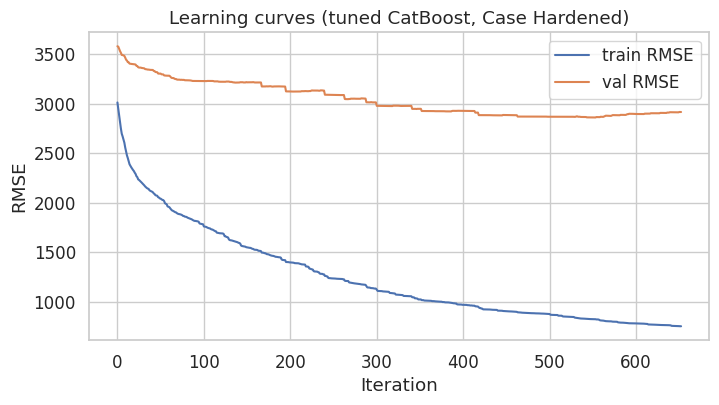


=== ТОП признаков (tuned CatBoost, Case Hardened) ===


,feature,importance
13,blue_score,19.172689
0,float,11.889697
15,weapon,11.284175
4,playside_blue,10.442245
7,stickers_avg_value,8.518567
3,backside_blue,7.968678
6,stickers_total_value,7.289745
1,pattern,6.712615
18,pattern_style,3.338170
9,slot0_price,3.131638


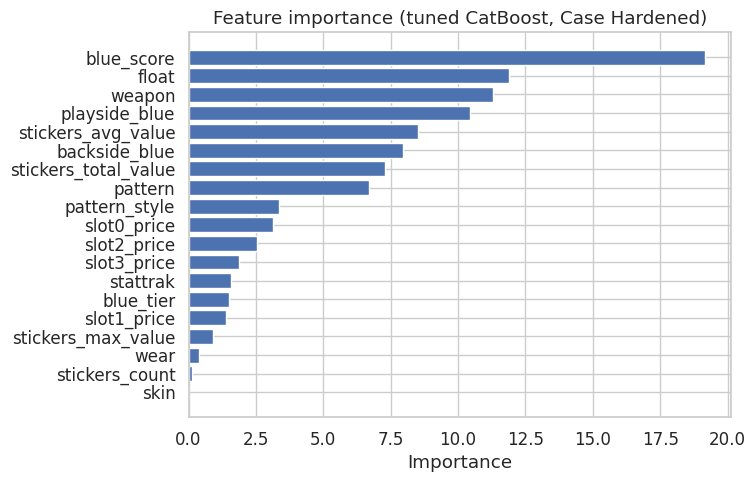

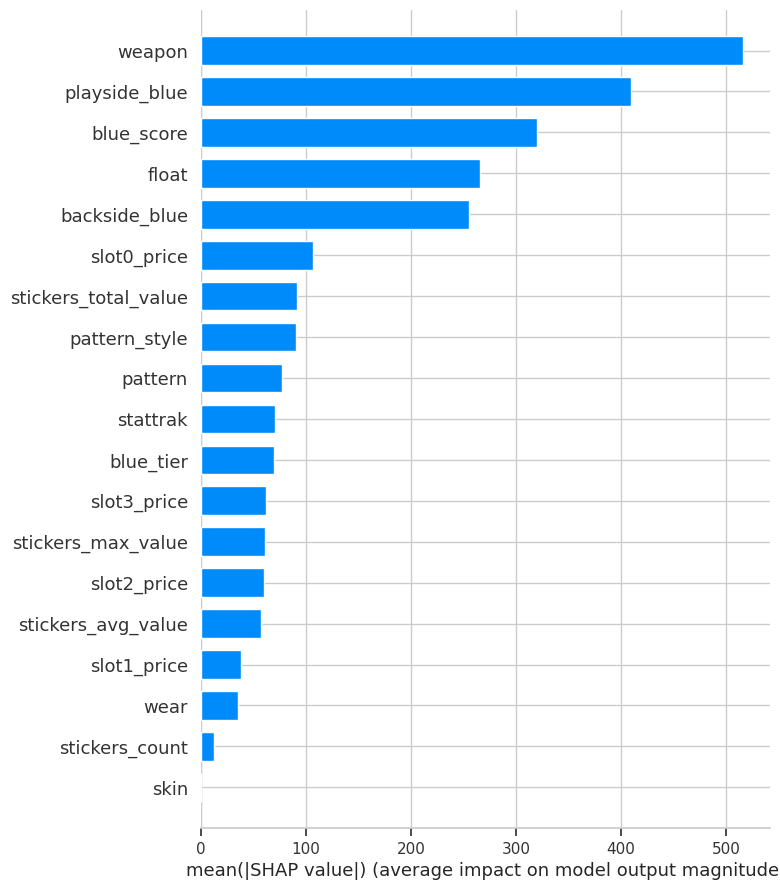

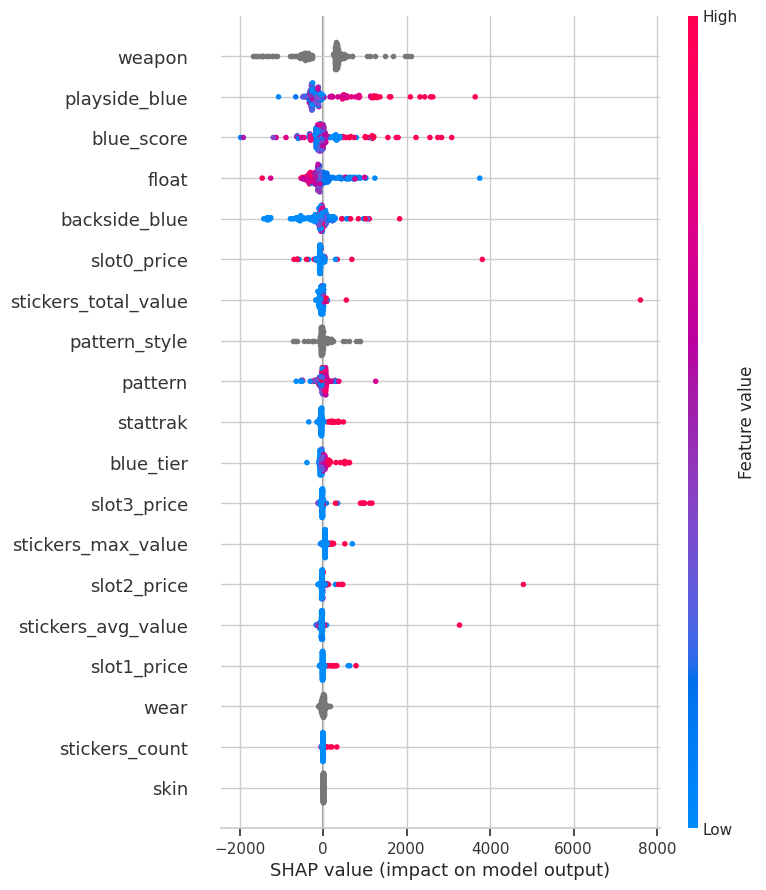

In [17]:

evals_result = tuned_model.get_evals_result()
train_rmse = evals_result["learn"]["RMSE"]
val_rmse = evals_result["validation"]["RMSE"]

plt.figure(figsize=(8, 4))
plt.plot(train_rmse, label="train RMSE")
plt.plot(val_rmse, label="val RMSE")
plt.xlabel("Iteration")
plt.ylabel("RMSE")
plt.title("Learning curves (tuned CatBoost, Case Hardened)")
plt.legend()
plt.show()

# 9.2 Feature importance

feat_importances = tuned_model.get_feature_importance(train_pool)
importances_df = pd.DataFrame({
    "feature": X.columns,
    "importance": feat_importances
}).sort_values("importance", ascending=False)

print("\n=== ТОП признаков (tuned CatBoost, Case Hardened) ===")
display(importances_df)

plt.figure(figsize=(7, 5))
plt.barh(importances_df["feature"], importances_df["importance"])
plt.gca().invert_yaxis()
plt.title("Feature importance (tuned CatBoost, Case Hardened)")
plt.xlabel("Importance")
plt.show()

# 9.3 SHAP-объяснения (на сэмпле)

explainer = shap.TreeExplainer(tuned_model)
X_sample = X_test.sample(min(200, len(X_test)), random_state=RANDOM_STATE)
shap_values = explainer.shap_values(X_sample)

shap.summary_plot(shap_values, X_sample, plot_type="bar")
plt.show()

shap.summary_plot(shap_values, X_sample)
plt.show()


##Оптимизация инференса: Fast CatBoost + замер времени

In [18]:

def measure_inference_time(model, X, n_runs: int = 5) -> float:
    times = []
    for _ in range(n_runs):
        start = time.time()
        _ = model.predict(X)
        end = time.time()
        times.append(end - start)
    return sum(times) / len(times)

time_base = measure_inference_time(baseline_model, X_test)
time_tuned = measure_inference_time(tuned_model, X_test)
time_lr = measure_inference_time(linreg_model, X_test)

print("=== Время инференса (секунд на весь X_test) ===")
print(f"CatBoost Baseline: {time_base:.4f} s")
print(f"CatBoost Tuned:    {time_tuned:.4f} s")
print(f"Linear Regression: {time_lr:.4f} s")

# Fast-модель (меньше деревьев/глубины => быстрее, чуть хуже качество)
fast_model = CatBoostRegressor(
    depth=6,
    learning_rate=0.1,
    iterations=400,
    loss_function="RMSE",
    eval_metric="RMSE",
    random_seed=RANDOM_STATE,
    od_type="Iter",
    od_wait=50,
    verbose=False,
)

fast_model.fit(train_pool, eval_set=val_pool, use_best_model=True)

y_pred_fast = fast_model.predict(test_pool)
mae_fast = mean_absolute_error(y_test, y_pred_fast)
rmse_fast = math.sqrt(mean_squared_error(y_test, y_pred_fast))
r2_fast = r2_score(y_test, y_pred_fast)
time_fast = measure_inference_time(fast_model, X_test)

print("\n=== Fast CatBoost (Case Hardened) ===")
print(f"MAE:  {mae_fast:.2f} $")
print(f"RMSE: {rmse_fast:.2f} $")
print(f"R²:   {r2_fast:.4f}")
print(f"Inference time: {time_fast:.4f} s")

speed_results = pd.DataFrame([
    {"model": "CatBoost Baseline", "MAE": mae_base, "RMSE": rmse_base, "R2": r2_base, "time_s": time_base},
    {"model": "CatBoost Tuned",    "MAE": mae_tuned, "RMSE": rmse_tuned, "R2": r2_tuned, "time_s": time_tuned},
    {"model": "CatBoost Fast",     "MAE": mae_fast, "RMSE": rmse_fast, "R2": r2_fast, "time_s": time_fast},
    {"model": "Linear Regression", "MAE": mae_lr, "RMSE": rmse_lr, "R2": r2_lr, "time_s": time_lr},
])

print("\n=== Качество vs скорость (Case Hardened) ===")
display(speed_results)


=== Время инференса (секунд на весь X_test) ===
CatBoost Baseline: 0.0104 s
CatBoost Tuned:    0.0036 s
Linear Regression: 0.0059 s

=== Fast CatBoost (Case Hardened) ===
MAE:  613.71 $
RMSE: 3554.73 $
R²:   0.3781
Inference time: 0.0073 s

=== Качество vs скорость (Case Hardened) ===


,model,MAE,RMSE,R2,time_s
0,CatBoost Baseline,574.594018,3579.180014,0.369522,0.010420
1,CatBoost Tuned,613.061748,3242.680445,0.482499,0.003606
2,CatBoost Fast,613.712021,3554.734121,0.378105,0.007319
3,Linear Regression,1012.460184,4272.351499,0.101669,0.005900


#W&B-логирование (отдельные run’ы для baseline, tuned, linreg)

In [25]:
# 12. Логирование экспериментов в W&B для Case Hardened

wandb.login()

def train_and_log_catboost_ch(run_name: str, params: dict, log_shap: bool = False):
    with wandb.init(
        project="cs2-ch-pricing",
        name=run_name,
        config=params
    ):
        model = CatBoostRegressor(**params)
        model.fit(train_pool, eval_set=val_pool, use_best_model=True, verbose=False)

        y_pred = model.predict(test_pool)
        mae = mean_absolute_error(y_test, y_pred)
        rmse = math.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)

        wandb.log({"MAE": mae, "RMSE": rmse, "R2": r2})

        evals_result = model.get_evals_result()
        train_rmse = evals_result["learn"]["RMSE"]
        val_rmse = evals_result["validation"]["RMSE"]

        for step, (tr, va) in enumerate(zip(train_rmse, val_rmse), start=1):
            wandb.log({"RMSE/train": tr, "RMSE/val": va}, step=step)

        # feature importance
        feat_importances = model.get_feature_importance(train_pool)
        importances_df = pd.DataFrame({
            "feature": X.columns,
            "importance": feat_importances
        }).sort_values("importance", ascending=False)

        plt.figure(figsize=(7, 5))
        plt.barh(importances_df["feature"], importances_df["importance"])
        plt.gca().invert_yaxis()
        plt.title(f"Feature Importance ({run_name})")
        plt.xlabel("Importance")
        wandb.log({"Feature Importance": wandb.Image(plt)})
        plt.close()

        # SHAP только для tuned
        if log_shap:
            X_sample = X_test.sample(min(200, len(X_test)), random_state=RANDOM_STATE)
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(X_sample)

            shap.summary_plot(shap_values, X_sample, plot_type="bar", show=False)
            wandb.log({f"SHAP Summary (bar) [{run_name}]": wandb.Image(plt)})
            plt.close()

            shap.summary_plot(shap_values, X_sample, show=False)
            wandb.log({f"SHAP Summary [{run_name}]": wandb.Image(plt)})
            plt.close()

        return model


def train_and_log_linreg_ch(run_name: str):
    numeric_features = NUM_FEATURES
    categorical_features = CAT_FEATURES

    preprocess = ColumnTransformer(
        transformers=[
            ("num", "passthrough", numeric_features),
            ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ]
    )

    model = Pipeline(steps=[
        ("preprocess", preprocess),
        ("regressor", LinearRegression())
    ])

    with wandb.init(
        project="cs2-ch-pricing",
        name=run_name,
        config={
            "model_type": "LinearRegression",
            "numeric_features": numeric_features,
            "categorical_features": categorical_features,
        }
    ):
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        mae = mean_absolute_error(y_test, y_pred)
        rmse = math.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)

        wandb.log({"MAE": mae, "RMSE": rmse, "R2": r2})

    return model


# Параметры baseline и tuned
baseline_params = {
    "depth": 8,
    "learning_rate": 0.05,
    "iterations": 1500,
    "loss_function": "RMSE",
    "eval_metric": "RMSE",
    "random_seed": RANDOM_STATE,
    "od_type": "Iter",
    "od_wait": 120,
    "verbose": False,
}

tuned_params = best_params.copy()
tuned_params.update({
    "loss_function": "RMSE",
    "eval_metric": "RMSE",
    "random_seed": RANDOM_STATE,
    "od_type": "Iter",
    "od_wait": 100,
    "verbose": False,
})

cb_base_wb  = train_and_log_catboost_ch("ch_catboost_baseline", baseline_params, log_shap=False)
cb_tuned_wb = train_and_log_catboost_ch("ch_catboost_tuned", tuned_params, log_shap=True)
lr_wb       = train_and_log_linreg_ch("ch_linear_regression")


MAE,▁
R2,▁
RMSE,▁
RMSE/train,█▇▇▆▅▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
RMSE/val,█▇▇▇▆▆▆▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAE,459.72371
R2,0.61257
RMSE,2686.68402
RMSE/train,332.80446
RMSE/val,2686.68585


MAE,▁
R2,▁
RMSE,▁
RMSE/train,█▆▆▆▆▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
RMSE/val,█▇▇▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAE,446.35566
R2,0.6243
RMSE,2645.67951
RMSE/train,289.30478
RMSE/val,2645.72129


MAE,▁
R2,▁
RMSE,▁
MAE,1013.99977
R2,0.10932
RMSE,4073.61562
